Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Regression problem: Is your target skewed? Then, log-transform it.
    - Classification: Are your classes imbalanced? Then, don't use just accuracy. And try `class_balance` parameter in scikit-learn.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Share at least 1 visualization on Slack.

You need to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

### Today
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)


### Yesterday
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)






In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

In [4]:
df = pd.read_csv('CA_Hosp_Mortality.csv', encoding = "ISO-8859-1")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Cleaning function

def wrangle(X):
    
    X = X.copy()
    
    X = X.drop(columns='OSHPDID')
    # Change column names to more appropriate names without caps
    X = X.rename(columns={'YEAR':'Year', 'COUNTY':'County', 'HOSPITAL':'Hospital',
                        'Procedure/Condition':'Procedure_Condition',
                        'Risk Adjuested Mortality Rate':'RAMR', '# of Deaths':'Number_Deaths',
                        '# of Cases':'Number_Cases', 'Hospital Ratings':'Hospital_Ratings',
                        'LONGITUDE':'Longitude', 'LATITUDE':'Latitude'
                       })  
    
    # Remove rows where the value is for the entire state
    X = X.query("County != 'AAAA'") # AAAA is county code for State

    # Remove procedures that are not in every year and hidden NaN values
    X.replace({'AAA Repair':np.nan, 'AAA Repair Unruptured':np.nan, '.':np.nan}, inplace=True)
    X.dropna(inplace=True)
    
    # Change numeric columns from string to float
    numerics = ['RAMR', 'Number_Deaths', 'Number_Cases']
    for column in numerics:
        X[column] = X[column].astype(float)
    
    # Engineer new column of Number of Deaths to Number of Cases ratio
    X['Deaths_Cases'] = X['Number_Deaths']/X['Number_Cases']
    
    # Creating numeric values for hospital rating since it is in least to best
    X['Hospital_Ratings'].replace({'Worse':1, 'As Expected':2, 'Better':3}, inplace=True)
    
    return X

newdf = wrangle(df)

C:\Users\John\Anaconda3\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning

In [6]:
target = 'Number_Deaths'
features = newdf.columns.drop('Number_Deaths').tolist()

train = newdf.query('Year < 2015')
test = newdf.query('Year >= 2015')

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9149, 10), (9149,), (3130, 10), (3130,))

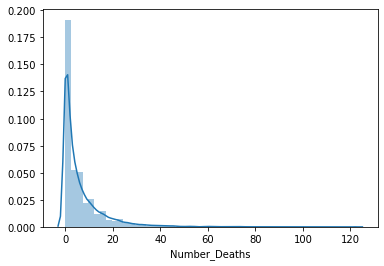

In [8]:
# Having number of deaths as target
# Distribution shows a majority number of deaths per case are below 10
sns.distplot(y_train);

In [25]:
# Baseline model
# Number of deaths averaged between all hospitals between 2012-2014
mean = train['Number_Deaths'].mean()
baseline = []
for _ in range(y_test.shape[0]):
    baseline.append(mean)
    
print('Mean Absolute Error:', mean_absolute_error(y_test, baseline))   
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, baseline)))
print('R2 Score:', r2_score(y_test, baseline))

Mean Absolute Error: 5.739296076981824
Root Mean Squared Error: 7.916722064739924
R2 Score: -0.03206082915220243


In [9]:
# Linear Regression model, beats the baseline
# R^2 score shows very weak linear correlation, poor model for testing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def LReg(X_train, y_train, X_test, y_test):
    X_train = X_train.select_dtypes(include='number')
    X_test = X_test.select_dtypes(include='number')
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))   
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 Score:', r2_score(y_test, y_pred))
    
    coeff_df = pd.DataFrame(model.coef_, X_test.columns)
    print(coeff_df)

LReg(X_train, y_train, X_test, y_test)

Mean Absolute Error: 2.8464825762800117
Root Mean Squared Error: 5.224245790475672
R2 Score: 0.5505703696883189
                  0
Year         -0.040
RAMR          0.243
Number_Cases  0.046
Deaths_Cases  3.196


I need to change to a different model since a linear correlation is not present.
Considering creating categorical variables for number of deaths binned and doing a logistic regression or random forest on this